## **Optimal Variational Quantum Ramsey Interferometer Simulation**

This code block imports the necessary libraries for building and simulating the quantum circuit, performing optimization, and visualizing the results.

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
import numpy as np
# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

Circuit Construction:

Creates a 3-qubit circuit.
Applies Ry rotations (π/2) to all qubits.
Defines a custom 2-layer entanglement function.
Applies the entanglement function with parameters.
Implements a Ramsey sequence (Z-axis evolution).
Reverses the entanglement using reversed parameters.
Applies final Rx rotations (π/2) to all qubits.
Measures all qubits.
Visualizes the complete circuit.

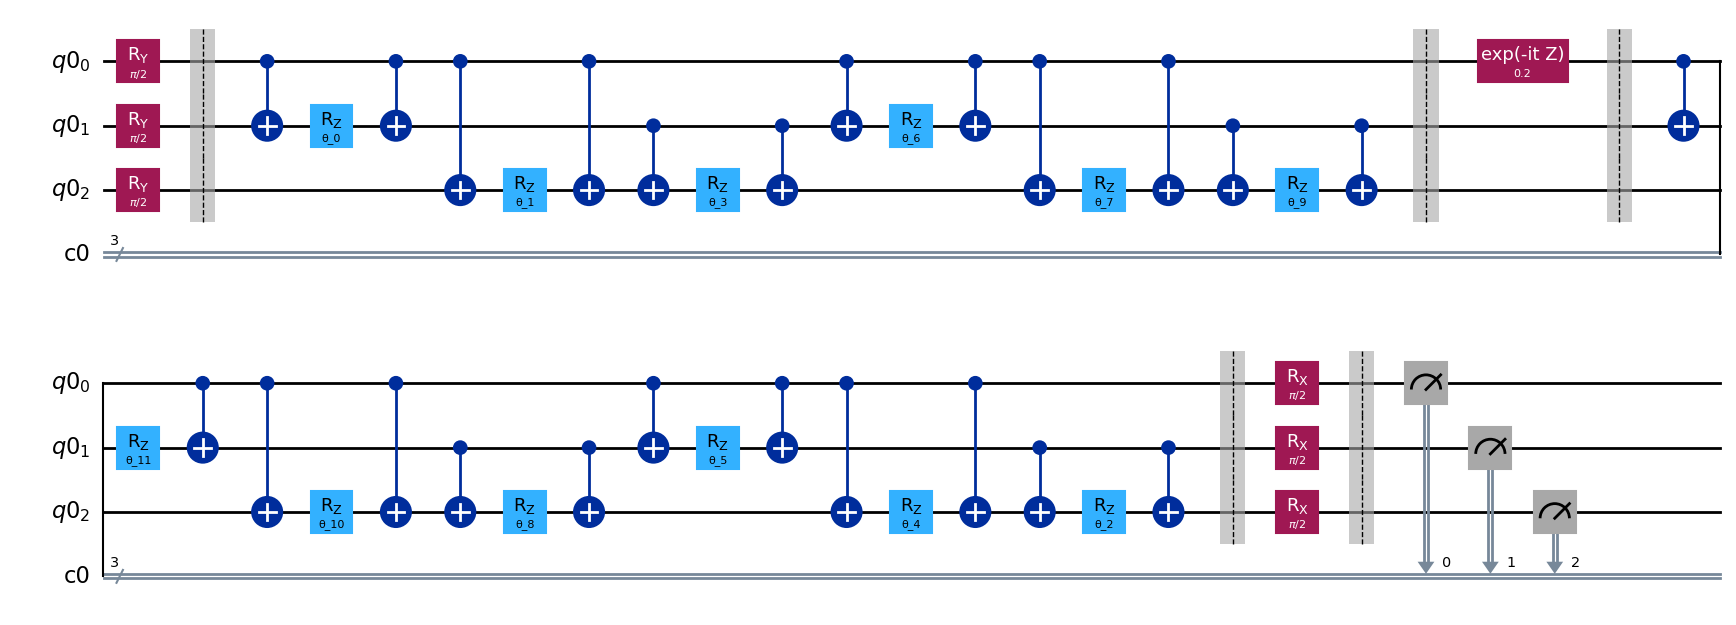

In [ ]:
# Define quantum and classical registers
qr = QuantumRegister(3)
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr, cr)

# Apply Ry rotations with pi/2 phase on all qubits
for i in range(3):
    qc.ry(np.pi/2, i)

qc.barrier()

# Define custom entanglement layer function
def custom_entanglement_layer(circuit, params):
    num_qubits = circuit.num_qubits
    for layer in range(2):  # 2 layers
        for i in range(num_qubits):
            for j in range(i+1, num_qubits):
                circuit.cx(i, j)
                circuit.rz(params[layer * (num_qubits * (num_qubits - 1)) + i * (num_qubits - 1) + j - 1], j)
                circuit.cx(i, j)

# Apply custom entanglement layer
num_layers = 2
params = [Parameter(f'θ_{i}') for i in range(num_layers * (3 * (3 - 1)))]
custom_entanglement_layer(qc, params)

qc.barrier()

# Define the operator for the evolution gate
Z = SparsePauliOp("Z")
operator = Z
evo = PauliEvolutionGate(operator, time=0.2)

# Apply the evolution gate
qc.append(evo, range(1))

qc.barrier()
# Reverse the entanglement
custom_entanglement_layer(qc, params[::-1])

qc.barrier()
# Apply Rx rotations with pi/2 phase on all qubits
for i in range(3):
    qc.rx(np.pi/2, i)

qc.barrier()
# Measure all qubits
qc.measure(qr, cr)

# Visualize the final circuit
qc.draw()

Selecting available backend quantum computer on IBM

In [ ]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

qiskit_runtime_service.__init__:INFO:2024-04-23 11:51:55,099: Default instance: ibm-q/open/main


'ibm_sherbrooke'

Optimizing the Circuit for the Backend

This code block deals with optimizing the circuit for potentially running it on actual quantum hardware.


In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(qc)

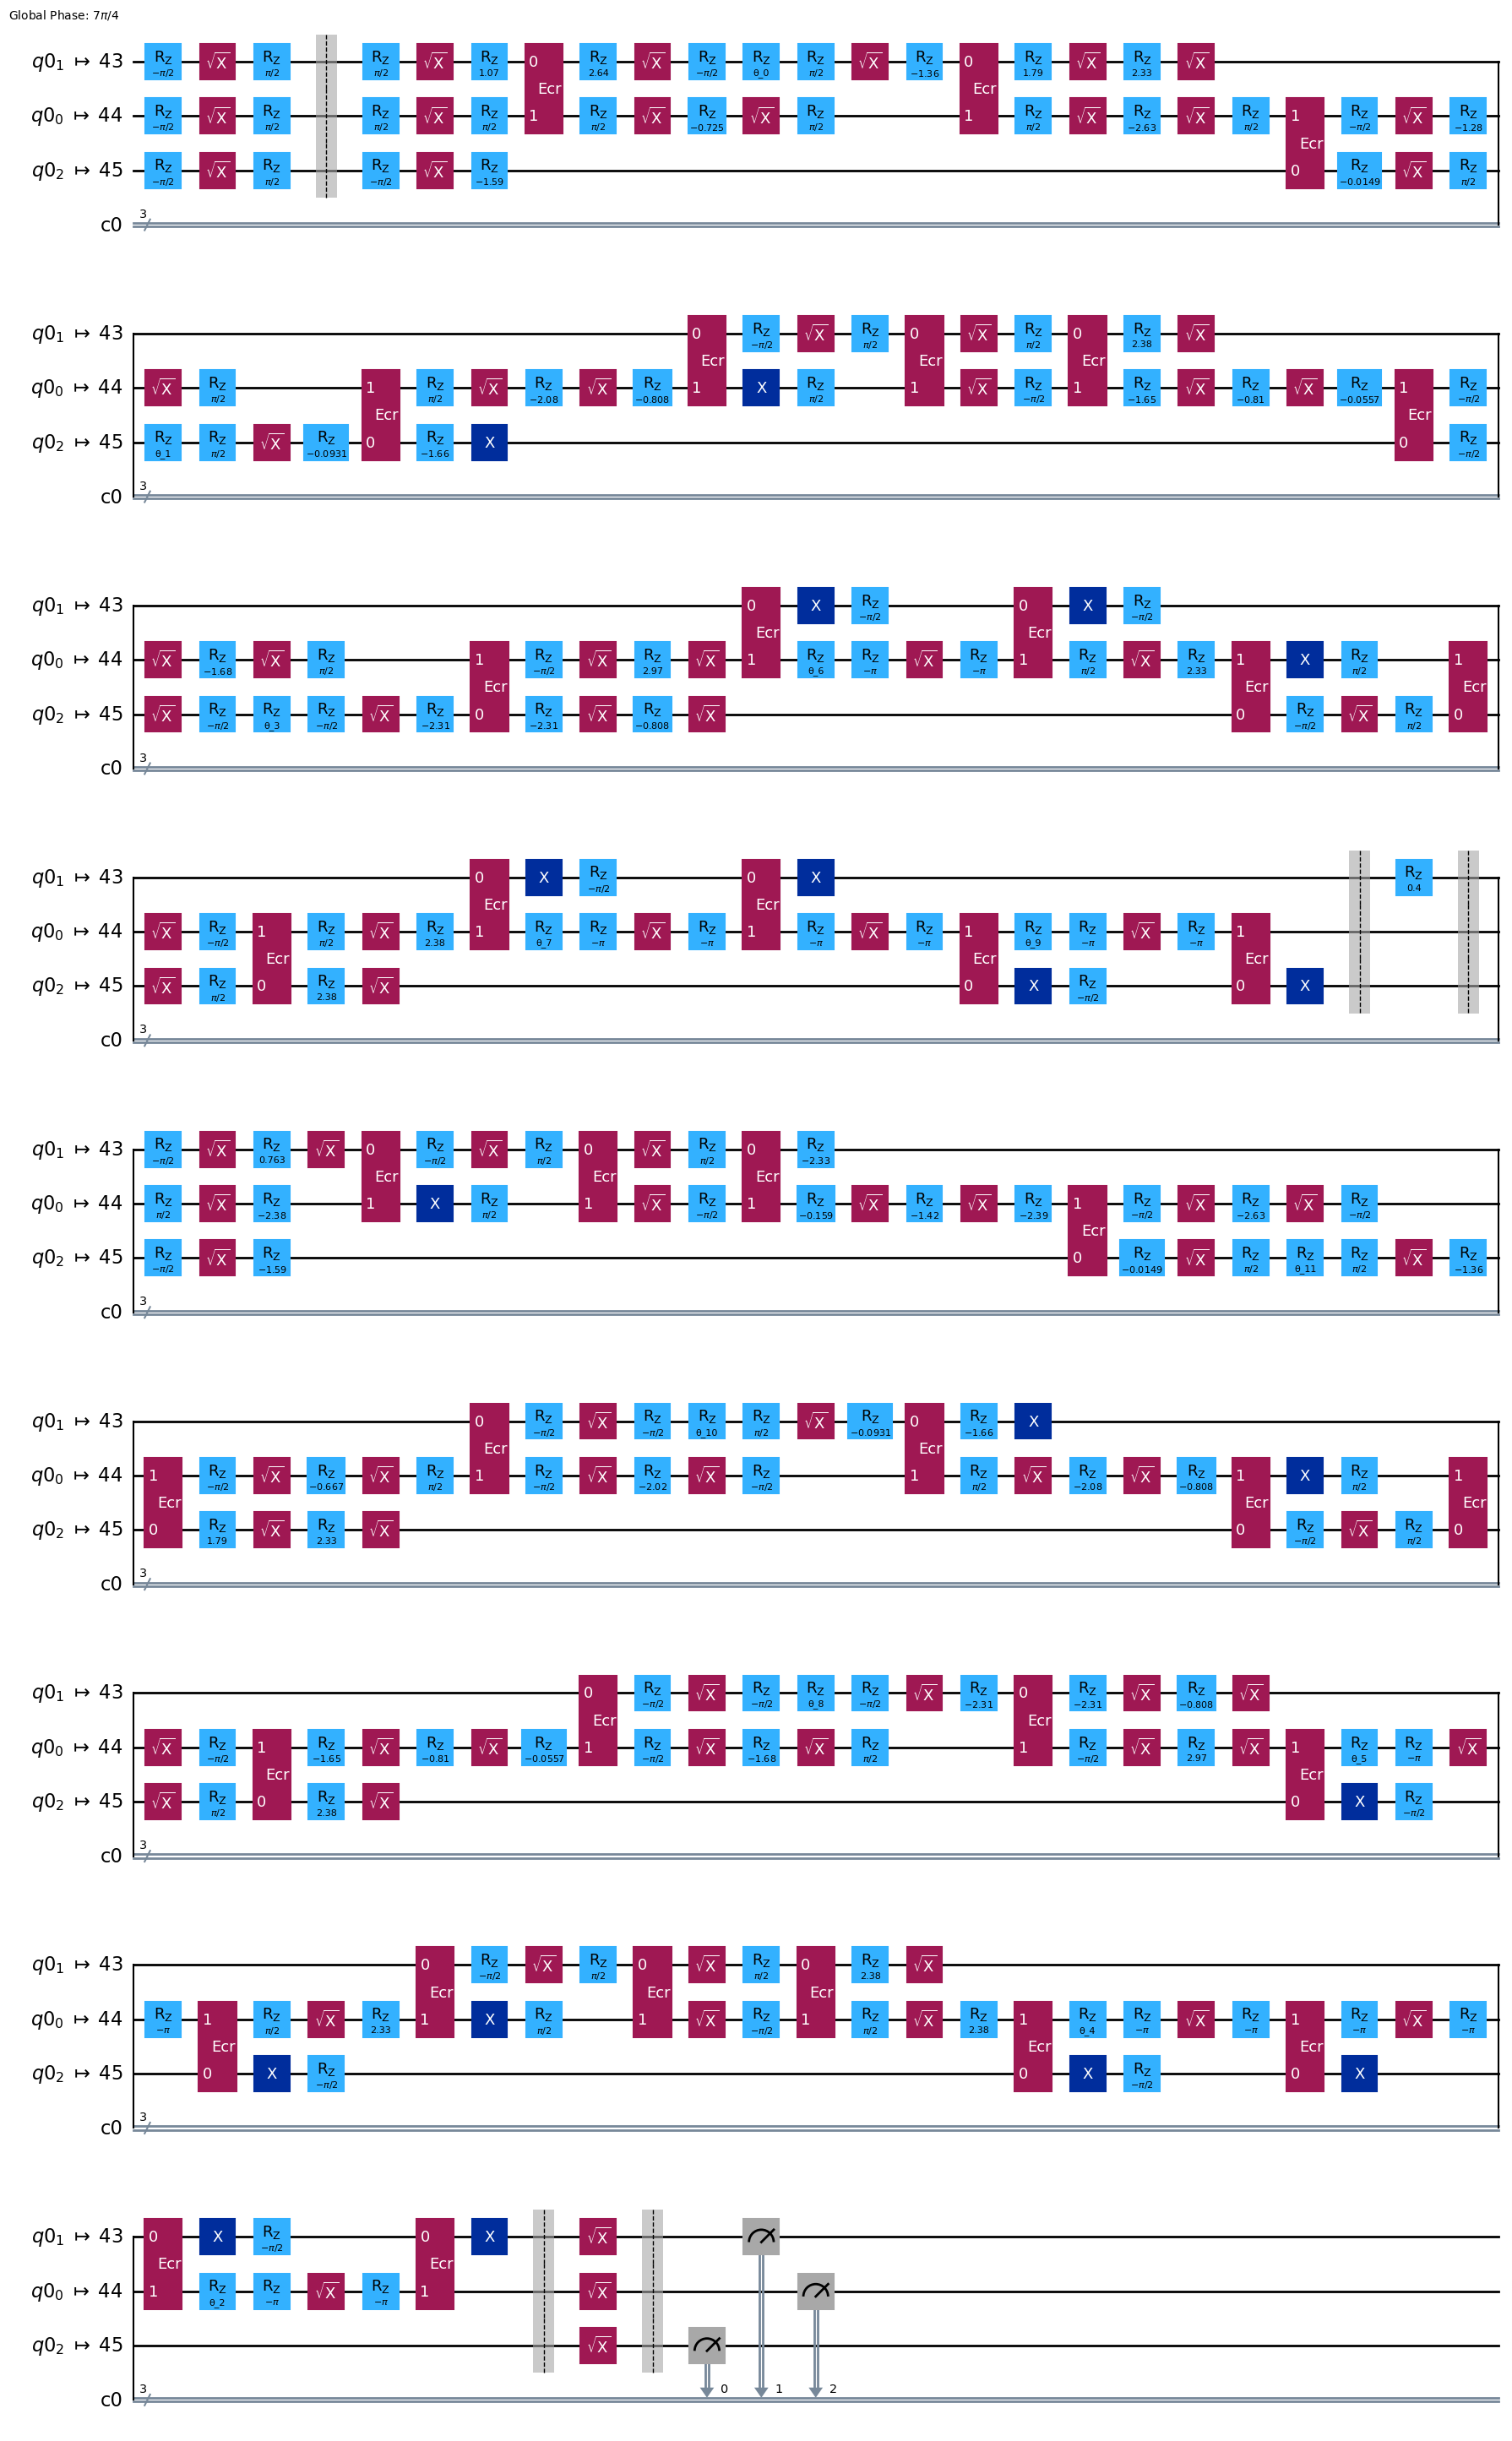

In [ ]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

This code defines the observable to be measured, which in this case is the Z-axis measurement on all three qubits ("ZZZ").

In [ ]:
from qiskit.quantum_info import SparsePauliOp

# Define the Z observable for each qubit
observable_z = SparsePauliOp.from_list([("ZZZ", 1)])  # Assuming ansatz_isa has 3 qubits

In [ ]:
observable_z_isa = observable_z.apply_layout(ansatz_isa.layout)

Then now we define a cost function.

In [ ]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    return energy

def build_callback(ansatz, hamiltonian, estimator, callback_dict):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(current_vector):
        """Callback function storing previous solution vector,
        computing the intermediate cost value, and displaying number
        of completed iterations and average time per iteration.

        Values are stored in pre-defined 'callback_dict' dictionary.

        Parameters:
            current_vector (ndarray): Current vector of parameters
                                      returned by optimizer
        """
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        pub = (ansatz, [hamiltonian], [current_vector])
        result = estimator.run(pubs=[pub]).result()
        current_cost = result[0].data.evs[0]
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
            end="\r",
            flush=True,
        )

    return callback

callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

Initial guesses are randomly generated.

In [ ]:
parameter_values = 2 * np.pi * np.random.rand(qc.num_parameters)
parameter_values

array([0.52907925, 1.29412448, 0.87521934, 1.79907308, 2.08584666,
       1.50118533, 5.66904538, 3.57526168, 0.06961241, 0.77450318,
       3.03323463, 1.25561526])

Now this code does the execution on the backend quantum computer.

In [ ]:
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 10_000

    callback = build_callback(ansatz_isa, observable_z_isa, estimator, callback_dict)

    res = minimize(
        cost_func,
        parameter_values,
        args=(ansatz_isa, observable_z_isa, estimator),
        method="cobyla",
        callback=callback,
    )

base_primitive._run:INFO:2024-04-23 12:07:44,772: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:08:10,160: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}


base_primitive._run:INFO:2024-04-23 12:08:35,285: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:09:00,289: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}


base_primitive._run:INFO:2024-04-23 12:09:31,304: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:09:55,852: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}


base_primitive._run:INFO:2024-04-23 12:10:19,981: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:11:29,682: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}


base_primitive._run:INFO:2024-04-23 12:11:54,934: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:13:07,146: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}


base_primitive._run:INFO:2024-04-23 12:13:31,687: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:14:01,860: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}


base_primitive._run:INFO:2024-04-23 12:14:26,817: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:14:51,470: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}


base_primitive._run:INFO:2024-04-23 12:15:30,874: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:15:56,087: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}


base_primitive._run:INFO:2024-04-23 12:16:27,931: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:16:52,893: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}


base_primitive._run:INFO:2024-04-23 12:17:26,444: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:17:51,286: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}


base_primitive._run:INFO:2024-04-23 12:18:16,832: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:18:42,964: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}


base_primitive._run:INFO:2024-04-23 12:19:08,840: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:19:33,092: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}


base_primitive._run:INFO:2024-04-23 12:19:57,521: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:20:32,525: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}


base_primitive._run:INFO:2024-04-23 12:21:25,194: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:21:50,389: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}


base_primitive._run:INFO:2024-04-23 12:22:16,717: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:22:42,226: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}


base_primitive._run:INFO:2024-04-23 12:23:07,527: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


Traceback (most recent call last):
  Cell In[26], line 7
    res = minimize(
  File /opt/conda/lib/python3.10/site-packages/scipy/optimize/_minimize.py:719 in minimize
    res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
  File /opt/conda/lib/python3.10/site-packages/scipy/optimize/_cobyla_py.py:35 in wrapper
    return func(*args, **kwargs)
  File /opt/conda/lib/python3.10/site-packages/scipy/optimize/_cobyla_py.py:293 in _minimize_cobyla
    xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,
  File /opt/conda/lib/python3.10/site-packages/scipy/optimize/_cobyla_py.py:281 in calcfc
    f = sf.fun(x)
  File /opt/conda/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:278 in fun
    self._update_fun()
  File /opt/conda/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:262 in _update_fun
    self._update_fun_impl()
  File /opt/conda/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.

## Making Sense Of Output

While our code did not run fully, we took the points of the iteration number and then its corresponding cost function and plotted the graph below.

Data Log:

base_primitive._run:INFO:2024-04-23 12:07:44,772: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:08:10,160: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}

###**Iters. done: 4 [Current cost: 0.1918800482901679]**

base_primitive._run:INFO:2024-04-23 12:08:35,285: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:09:00,289: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}

###**Iters. done: 5 [Current cost: 0.12200354692367472]**

base_primitive._run:INFO:2024-04-23 12:09:31,304: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:09:55,852: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}

###**Iters. done: 6 [Current cost: 0.08659017689097862]**

base_primitive._run:INFO:2024-04-23 12:10:19,981: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:11:29,682: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}

###**Iters. done: 7 [Current cost: -0.08437195224482931]**

base_primitive._run:INFO:2024-04-23 12:11:54,934: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:13:07,146: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}

###**Iters. done: 8 [Current cost: -0.05644302449414271]**

base_primitive._run:INFO:2024-04-23 12:13:31,687: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:14:01,860: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}

###**Iters. done: 9 [Current cost: 0.0896734715979856]**

base_primitive._run:INFO:2024-04-23 12:14:26,817: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:14:51,470: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}

###**Iters. done: 10 [Current cost: -0.07382545821422568]**

base_primitive._run:INFO:2024-04-23 12:15:30,874: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:15:56,087: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}

###**Iters. done: 11 [Current cost: -0.09247941882200097]**

base_primitive._run:INFO:2024-04-23 12:16:27,931: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:16:52,893: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}

###**Iters. done: 12 [Current cost: -0.05068864606545493]**

base_primitive._run:INFO:2024-04-23 12:17:26,444: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:17:51,286: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}

###**Iters. done: 13 [Current cost: -0.10540490586961687]**

base_primitive._run:INFO:2024-04-23 12:18:16,832: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:18:42,964: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}

###**Iters. done: 14 [Current cost: 0.0805368221827125]**

base_primitive._run:INFO:2024-04-23 12:19:08,840: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:19:33,092: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}

###**Iters. done: 15 [Current cost: -0.010524337530539371]**

base_primitive._run:INFO:2024-04-23 12:19:57,521: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:20:32,525: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}

###**Iters. done: 16 [Current cost: -0.07619708258018901]**


base_primitive._run:INFO:2024-04-23 12:21:25,194: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:21:50,389: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}

###**Iters. done: 17 [Current cost: -0.09738854082151382]**

base_primitive._run:INFO:2024-04-23 12:22:16,717: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
base_primitive._run:INFO:2024-04-23 12:22:42,226: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}

###**Iters. done: 18 [Current cost: -0.084094259206147]**

## BAD OUTPUT:

base_primitive._run:INFO:2024-04-23 12:23:07,527: Submitting job using options {'options': {'default_shots': 10000}, 'version': 2, 'support_qiskit': True}
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.

Traceback (most recent call last):
  Cell In[26], line 7
    res = minimize(
  File /opt/conda/lib/python3.10/site-packages/scipy/optimize/_minimize.py:719 in minimize
    res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
  File /opt/conda/lib/python3.10/site-packages/scipy/optimize/_cobyla_py.py:35 in wrapper
    return func(*args, **kwargs)
  File /opt/conda/lib/python3.10/site-packages/scipy/optimize/_cobyla_py.py:293 in _minimize_cobyla
    xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,
  File /opt/conda/lib/python3.10/site-packages/scipy/optimize/_cobyla_py.py:281 in calcfc
    f = sf.fun(x)
  File /opt/conda/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:278 in fun
    self._update_fun()
  File /opt/conda/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:262 in _update_fun
    self._update_fun_impl()
  File /opt/conda/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:163 in update_fun
    self.f = fun_wrapped(self.x)
  File /opt/conda/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:145 in fun_wrapped
    fx = fun(np.copy(x), *args)
  Cell In[19], line 14 in cost_func
    result = estimator.run(pubs=[pub]).result()
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/estimator.py:154 in run
    return self._run(coerced_pubs)  # type: ignore[arg-type]
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/base_primitive.py:154 in _run
    return self._session.run(
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/session.py:36 in _wrapper
    return func(self, *args, **kwargs)
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/session.py:189 in run
    job = self._service.run(
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:883 in run
    raise IBMRuntimeError(f"Failed to run program: {ex}") from None
IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

Use %tb to get the full traceback.

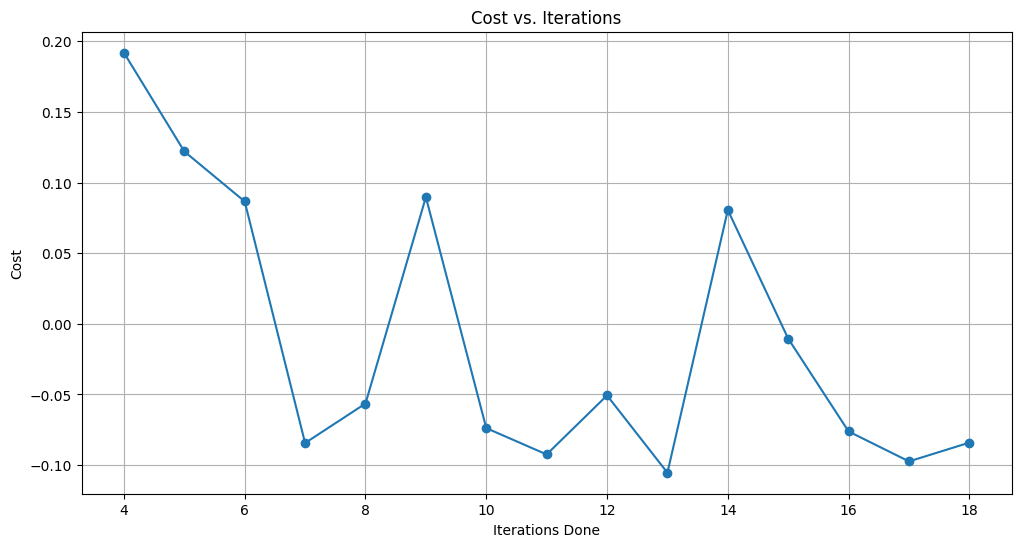

In [ ]:
import matplotlib.pyplot as plt

# Data points from the logs
iterations = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
costs = [0.1918800482901679, 0.12200354692367472, 0.08659017689097862, -0.08437195224482931, -0.05644302449414271, 0.0896734715979856, -0.07382545821422568, -0.09247941882200097, -0.05068864606545493, -0.10540490586961687, 0.0805368221827125, -0.010524337530539371, -0.07619708258018901, -0.09738854082151382, -0.084094259206147]


plt.figure(figsize=(12, 6))
plt.plot(iterations, costs, marker='o', linestyle='-')

plt.xlabel("Iterations Done")
plt.ylabel("Cost")
plt.title("Cost vs. Iterations")

plt.grid(True)
plt.show()